In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import os
import torch
import argparse
import yaml
from numba import cuda

from helpers.density_estimator import DensityEstimator
from helpers.ANODE_training_utils import train_ANODE, plot_ANODE_losses
from helpers.data_transforms import clean_data
from helpers.physics_functions import get_bins, get_bins_for_scan, curve_fit_m_inv, bkg_fit_cubic, bkg_fit_quintic, bkg_fit_septic
from helpers.plotting import *
from helpers.evaluation import *
from helpers.flow_sampling import *

/global/homes/r/rmastand/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
bkg_fit_type = "quintic"
num_bins_SR = 12

if bkg_fit_type == "cubic": bkg_fit_function = bkg_fit_cubic
elif bkg_fit_type == "quintic": bkg_fit_function = bkg_fit_quintic
elif bkg_fit_type == "septic": bkg_fit_function = bkg_fit_septic

use_inner_bands = False
if use_inner_bands: bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
else: bands = ["SBL", "SR", "SBH"]

train_samesign = False
if train_samesign: samesign_id = "SS"
else: samesign_id = "OS"

feature_id = "mix_2"
configs ="CATHODE_8"
feature_list = "dimu_pt,mu0_ip3d,mu1_ip3d,dimu_mass"
    
feature_set = [f for f in feature_list.split(",")]
print(f"Using feature set {feature_set}")
num_features = len(feature_set) - 1 # context doesn't count


Using feature set ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


In [3]:


import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
path_to_config_file = f"{working_dir}/configs/{configs}.yml"


# computing
device = cuda.get_current_device()
device.reset()
torch.set_num_threads(2)
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)


Using device: cuda


# load in the data -- this is used to fit to the SB / SR

In [4]:
data_dict = {}

# dataset for the bump hunt only
with open(f"{processed_data_dir}/bootstrap0_{samesign_id}_test_band_data", "rb") as ifile:
    test_data_dict = pickle.load(ifile)

print(f"{processed_data_dir}/bootstrap0_{samesign_id}_test_band_data", "rb")
for b in bands:
    num_events_band = test_data_dict[b]["dimu_mass"].shape[0]
    data_dict[b] = np.empty((num_events_band, num_features+1))
    for i, feat in enumerate(feature_set):
        data_dict[b][:,i] = test_data_dict[b][feat].reshape(-1,1).reshape(-1,)
    print("{b} data has shape {length}.".format(b = b, length = data_dict[b].shape))


/global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/processed_data/bootstrap0_OS_test_band_data rb
SBL data has shape (6924, 4).
SR data has shape (1692, 4).
SBH data has shape (3716, 4).


Defining bins on the fly...


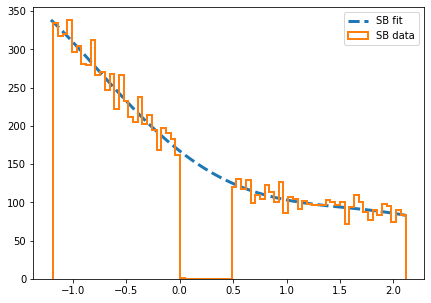

In [5]:
data_dict["SBL"] = clean_data(data_dict["SBL"])
data_dict["SBH"] = clean_data(data_dict["SBH"])

# to draw peakless samples from the SR, we need to first do a bkg fit in the SB
masses_to_fit = np.hstack((data_dict["SBL"][:,-1], data_dict["SBH"][:,-1]))


# for a single window, we can define the SR / SB bins on the fly
print("Defining bins on the fly...")
SB_left, SR_left = np.min(data_dict["SBL"][:,-1].reshape(-1)),  np.max(data_dict["SBL"][:,-1].reshape(-1))
SR_right, SB_right = np.min(data_dict["SBH"][:,-1].reshape(-1)),  np.max(data_dict["SBH"][:,-1].reshape(-1))
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, binning="linear", num_bins_SR=num_bins_SR)
x = np.linspace(SB_left, SB_right, 100) # plot curve fit

popt_0, _, _, _, _ = curve_fit_m_inv(masses_to_fit, bkg_fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
    
plt.figure(figsize = (7,5))
plt.plot(x, bkg_fit_function(x, *popt_0), lw = 3, linestyle = "dashed", label = "SB fit")
plt.hist(masses_to_fit, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = "SB data") 

 
plt.legend()
plt.show()
        

Load in the flows and generate samples

In [6]:
if train_samesign: num_samples = [10*1433,10*1433,10*1434,10*1434,10*1434]
else: num_samples = [10*2466,10*2466,10*2466,10*2467,10*2467]


flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap0_{samesign_id}/{feature_id}/{configs}/"


bootstrap_start, bootstrap_stop = 2000, 2101

sampled_features = {i:[] for i in range(bootstrap_start, bootstrap_stop)}

for i in [6,7,8,9,10]: # flow seeds to read in


    # load in the best flow model
    loc_flow_training_dir = f"{flow_training_dir}/seed{i}"
    train_losses = np.load(os.path.join(loc_flow_training_dir, f"flow_train_losses.npy"))
    val_losses = np.load(os.path.join(loc_flow_training_dir, f"flow_val_losses.npy"))
    best_epoch = np.nanargmin(val_losses) - 1
    model_path = f"{loc_flow_training_dir}/flow_epoch_{best_epoch}.par"
    eval_model = DensityEstimator(path_to_config_file, num_features, eval_mode=True,load_path=model_path,device=device, verbose=False,bound=False)

    for bs in range(bootstrap_start, bootstrap_stop):
        if bs % 20 == 0:
            print(f"Bootstrapping {bs}")

        torch.manual_seed(bs)
        np.random.seed(bs)
    
        mass_samples = get_mass_samples(SB_left, SB_right, bkg_fit_type, num_samples[i-6], popt_0)
        feature_samples = get_flow_samples(eval_model, mass_samples) 
        sampled_features[bs].append(feature_samples)


            


DensityEstimator has 3912 parameters
Loading model parameters from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/models/bootstrap0_OS/mix_2/CATHODE_8//seed6/flow_epoch_151.par
Bootstrapping 2000
Bootstrapping 2020
Bootstrapping 2040
Bootstrapping 2060
Bootstrapping 2080
Bootstrapping 2100
DensityEstimator has 3912 parameters
Loading model parameters from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/models/bootstrap0_OS/mix_2/CATHODE_8//seed7/flow_epoch_347.par
Bootstrapping 2000
Bootstrapping 2020
Bootstrapping 2040
Bootstrapping 2060
Bootstrapping 2080
Bootstrapping 2100
DensityEstimator has 3912 parameters
Loading model parameters from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/models/bootstrap0_OS/mix_2/CATHODE_8//seed8/flow_epoch_377.par
Bootstrapping 2000
Bootstrapping 2020
Bootstrapping 2040
Bootstrapping 2060
Bootstrapping 2080
Bootstrapping 2100
DensityEstimator has 3912 parameters
Loading model paramet

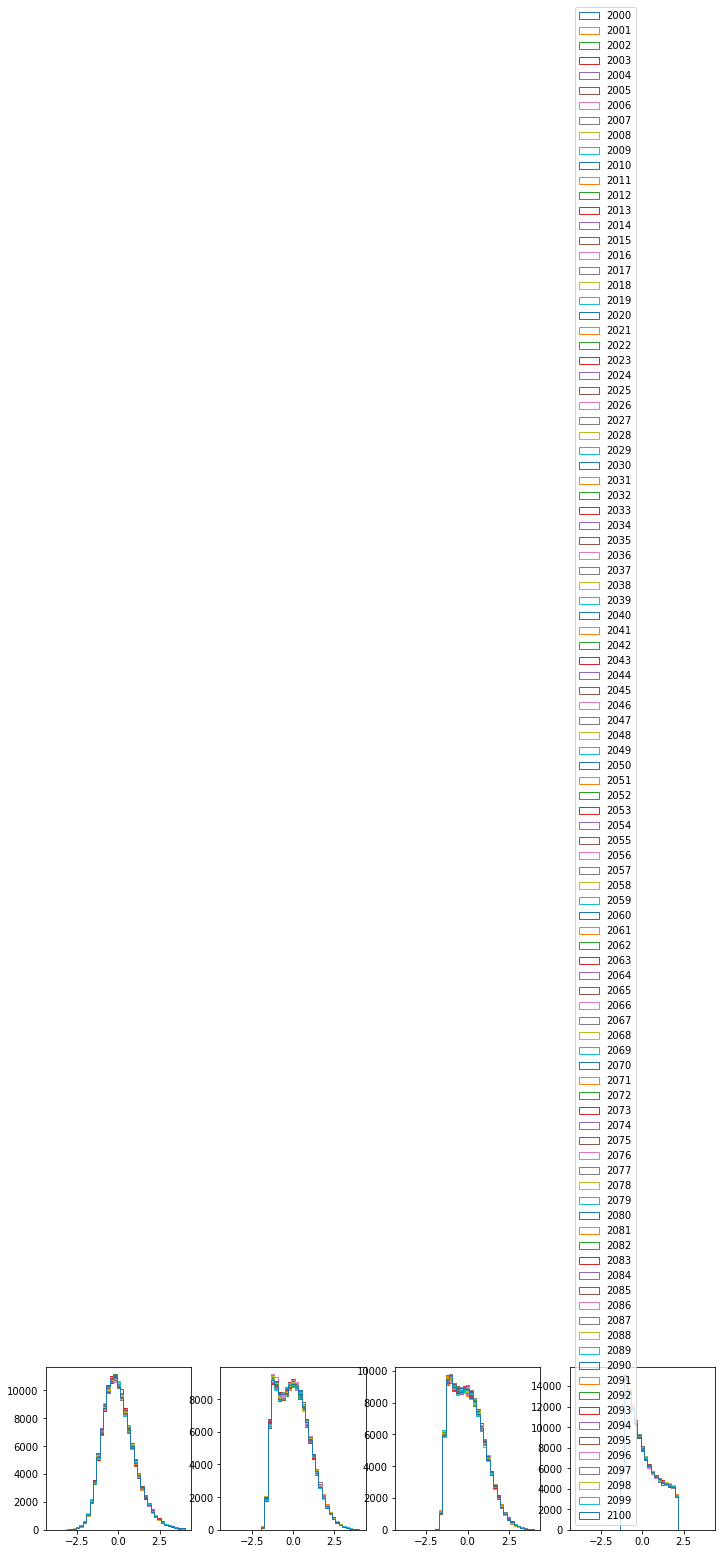

In [7]:

fig, ax = plt.subplots(1, 4, figsize = (12, 3))

for bs in range(bootstrap_start, bootstrap_stop):
    sampled_features[bs] = np.vstack(sampled_features[bs])
    for j in range(4):
        ax[j].hist(sampled_features[bs][:,j], bins = np.linspace(-4,4, 40), histtype = "step", label = bs)

plt.legend()
plt.show()
    
        

In [8]:
for bs in range(bootstrap_start, bootstrap_stop):  
    in_SR = (sampled_features[bs][:,-1] >= SR_left) & (sampled_features[bs][:,-1] <= SR_right)
    in_SBL = (sampled_features[bs][:,-1] < SR_left)
    in_SBH = (sampled_features[bs][:,-1] > SR_right)

    flow_dict_SR, flow_dict_SBL, flow_dict_SBH = {},{},{}
    
    for i,feat in enumerate(feature_set):
        
        flow_dict_SR[feat] = sampled_features[bs][in_SR][:,i].reshape(-1,1)
        flow_dict_SBL[feat] = sampled_features[bs][in_SBL][:,i].reshape(-1,1)
        flow_dict_SBH[feat] = sampled_features[bs][in_SBH][:,i].reshape(-1,1)

    flow_dict = {"SR":flow_dict_SR, "SBL":flow_dict_SBL, "SBH":flow_dict_SBH}


    with open(f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_12_03/processed_data/bkg_samples/bootstrap{bs}_{samesign_id}_test_band_data", "wb") as ofile:
        pickle.dump(flow_dict, ofile)
        
        
    
            


In [4]:
for i in range(401, 1001):
    print(f"python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd {i} -seeds 1,2,3,4,5 -run_null")
    #print f"python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd {i} -seeds 1,2,3,4,5 -run_null -train_samesign"

python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd 401 -seeds 1,2,3,4,5 -run_null
python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd 402 -seeds 1,2,3,4,5 -run_null
python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd 403 -seeds 1,2,3,4,5 -run_null
python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd 404 -seeds 1,2,3,4,5 -run_null
python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd 405 -seeds 1,2,3,4,5 -run_null
python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd 406 -seeds 1,2,3,4,5 -run_null
python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd 407 -seeds 1,2,3,4,5 -run_null
python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd 408 -seeds 1,2,3,4,5 -run_null
python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quintic -n_bins 12 -bd 409 -seeds 1,2,3,4,5 -run_null
python 07_run_bump_hunt.py -fid mix_2 -ne 100 -fit quin